In [1]:
'''
Analyze power efficiency based on laser displacement measurement
Author: Yitian Shao
Created on 2023.01.03
'''

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import mlab
import pandas as pd
import scipy.io as scio
from scipy import signal
import seaborn as sns

plt.rc('font', size=10, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rcParams['lines.linewidth'] = 1.125
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['errorbar.capsize'] = 4

figSize_inch = (3.2, 2.4)

''' Define Color Here '''
pltBlue = (32/255,120/255,180/255)
pltRed = (180/255,32/255,32/255)

''' Remove warnings '''
import warnings
warnings.filterwarnings('ignore')


In [2]:
def aPlot(figName='', is3D = False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3), dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassSmooth(datain, cutFreqRatio = 0.05, order = 8):
    b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeData(fileName, numFormat, frontCode='', rearCode='', isString=False):
    segStr = re.findall(frontCode+numFormat+rearCode, fileName)
    if segStr:
        if isString:
            return segStr[0]
        else:
            numData = float(re.findall(numFormat, segStr[0])[0])
    else:
        numData = None
    return numData

sine60mm1Hz7kV0gr
Sampling frequenecy = 98.00 Hz


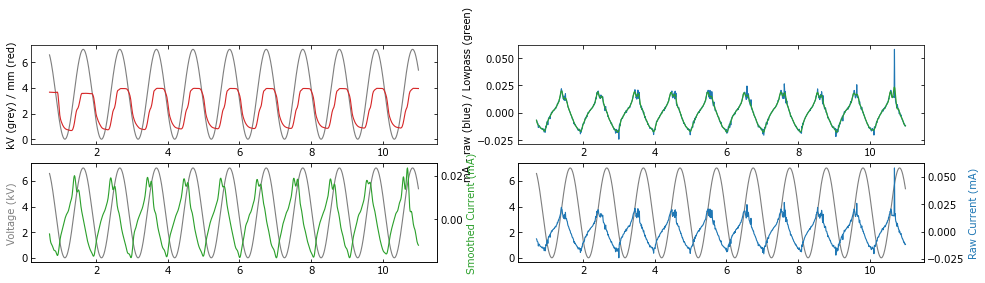

,Label,Waveform,TubeLength_mm,SinFreq_Hz,Voltage_kV,Load_gram,VoltageData_kV,DisplData_mm,CurrentData_mA
0,sine60mm1Hz7kV0gr,sine,60.0,1.0,7.0,0.0,"[6.5727, 6.4616, 6.3373, 6.2038, 6.0572, 5.903...","[3.6667, 3.6657, 3.6677, 3.6641, 3.665, 3.667,...","[-0.00672, -0.007580000000000001, -0.00902, -0..."


In [3]:
'''
Load and preprocess displacement, voltage, current data
'''

# Parameter of Trek 610E High Voltage Amplifier
VoltageScaleFactor = 1.0 # (1V monitor voltage = 1kV actual voltage)
CurrentScaleFactor = 0.2 # (1V monitor voltage = 0.2mA actual current)

measureDataPath = './PowerData20221221'

disp = True

Fs = None 

laserData = []

''' Data preprocess '''
for root, directories, files in walk(measureDataPath):
    for fileName in files:
        tubeLen = decodeData(fileName, '\d+', rearCode='mm')
        sinFreq = decodeData(fileName, '\d+', rearCode='Hz') 
        voltage = decodeData(fileName, '\d+', rearCode='kV') 
        loadWeight = decodeData(fileName, '\d+', rearCode='gr')

        waveform = decodeData(fileName, 'pulse', isString=True)  # Data20221221
        if waveform is None:
            waveform = decodeData(fileName, 'sine', isString=True)  # Data20221221

        dLabel = ""
        if waveform is not None:
            dLabel = dLabel + waveform
        if tubeLen is not None:
            dLabel = dLabel + ("%dmm" % tubeLen)           
        if sinFreq is not None:
            dLabel = dLabel + ("%dHz" % sinFreq)
        if voltage is not None:
            dLabel = dLabel + ("%dkV" % voltage)
        if loadWeight is not None:
            dLabel = dLabel + ("%dgr" % loadWeight)
        print(dLabel)
        
        readData = pd.read_csv(ospa.join(root, fileName), header = None)
        
        voltageData = None
        dispData = None
        currentData = None
        if readData is not None:       
            t = readData[0].to_numpy()
            diffT = np.diff(t)
            diffT = diffT[diffT > 0]
            SampleRate = int(1.0/np.mean(diffT))
            if SampleRate != Fs:
                if Fs is None:
                    Fs = SampleRate
                    print("Sampling frequenecy = %.2f Hz" % Fs)
                else:
                    print("Sampling frequenecy of current data %.2fHz differs from the Fs = %.2f Hz" % (SampleRate, Fs))
            
            voltageData = readData[1].to_numpy(dtype='float64') * VoltageScaleFactor
            dispData = readData[2].to_numpy()
            currentData = readData[3].to_numpy(dtype='float') * CurrentScaleFactor
            
            smCurrent = lowpassSmooth(currentData, cutFreqRatio = (10/Fs), order = 10)
            
            t = np.arange(voltageData.shape[0])/Fs;
            ind = (t > 0.7) & (t < 11.0) # Use data from ? sec to ? sec only!
                
            if disp: 
                _,ax = plt.subplots(2,2,dpi=72, figsize=(16,4))
                ax[0][0].plot(t[ind], voltageData[ind], color='tab:grey'); 
                ax[0][0].plot(t[ind], dispData[ind], color='tab:red')
                ax[0][0].set_ylabel('kV (grey) / mm (red)')
                ax[0][1].plot(t[ind], currentData[ind], color='tab:blue')
                ax[0][1].plot(t[ind], smCurrent[ind], color='tab:green')
                ax[0][1].set_ylabel('mA - raw (blue) / Lowpass (green)')
          
                
                ax[1][0].plot(t[ind], voltageData[ind], color='tab:grey');
                ax[1][0].set_ylabel('Voltage (kV)', color='tab:grey')
                ax3b = ax[1][0].twinx() 
                ax3b.plot(t[ind], smCurrent[ind], color='tab:green');
                ax3b.set_ylabel('Smoothed Current (mA)', color='tab:green')
                
                ax[1][1].plot(t[ind], voltageData[ind], color='tab:grey');
                ax4b = ax[1][1].twinx() 
                ax4b.plot(t[ind], currentData[ind], color='tab:blue');
                ax4b.set_ylabel('Raw Current (mA)', color='tab:blue')
                
                plt.show();

        laserData.append([dLabel, waveform, tubeLen, sinFreq, voltage, loadWeight, voltageData[ind], dispData[ind], 
                          currentData[ind]])

laserData = pd.DataFrame(laserData, columns = ['Label', 'Waveform', 'TubeLength_mm', 'SinFreq_Hz', 'Voltage_kV', 'Load_gram',
                                               'VoltageData_kV', 'DisplData_mm', 'CurrentData_mA'])  

laserData.tail(10)
        

In [ ]:
'''
Compute mechanical power output and electrical power consumption: Pulse
'''

laserData[laserData.Label == 'pulse60mm1Hz6kV5gr'] = None
laserData[laserData.Label == 'pulse60mm1Hz7kV5gr'] = None

labels = laserData.Label.unique()
print(labels)

segNum = 8 # Number of valid segments

dataFeature = []

for aLabel in labels:
    selectedData = laserData.loc[(laserData['Label'] == aLabel)]

    pMechData = []
    pElecData = []
    
    for index, row in selectedData.iterrows():
        if row["Waveform"] == 'pulse' and row["Load_gram"] > 0:
            loadForce = row["Load_gram"] * 9.8e-3 # Converted to SI Unit (N)
            
            voltage = row["VoltageData_kV"] * 1.0e3 # Converted to SI Unit (V)
            displacement = row["DisplData_mm"] * 1.0e-3 # Converted to SI Unit (m)
            current = row["CurrentData_mA"] * 1.0e-3 # Converted to SI Unit (A)
            t = np.arange(voltage.shape[0])/Fs

            chargingInd = np.where(np.diff(displacement) > 0)[0] # Only use segment of data in weight-lifting phase
            
            tmp = np.where(np.diff(displacement[chargingInd]) < -0.0005)[0]
            segEnd = chargingInd[tmp[1:]]+1 # End of a segment (index+1)
            segStart = chargingInd[tmp[:-1]+1] # Start of a segment
            
            segEnd = segEnd[:segNum]
            segStart = segStart[:segNum]

            # Plot data segmentation
            _,ax = plt.subplots(1,2,dpi=72, figsize=(16,2))
            ax1b = ax[1].twinx()
            
            # Show the complete signals
            ax[0].plot(t, displacement, '--', color='#FFD0D0')
            ax[1].plot(t, voltage, '--', color='#D0D0D0')
            ax1b.plot(t, current, '--', color='#D0FFD0')
            
            # X-axis labels
            ax[0].set_xlabel("Time (sec),  Seg.T: ")
            # Y-axis labels
            ax[0].set_ylabel(row["Label"] + '\nDisplacement (m)')
            ax[1].set_ylabel('Voltage (V)', color='tab:grey')
            ax1b.set_ylabel('Current (A)', color='tab:green')
           
            pMech = []
            pElec = []
            pRatio = []
            for i0, i1 in zip(segStart, segEnd):
                
                i0 = np.where(voltage[i0:i1] > 500)[0][0] + i0
                i1 = np.argmax(displacement[i0:i1]) + i0
                
                t_seg = t[i0:i1]
                dT = 1/Fs
                segT = t_seg[-1] - t_seg[0]
                segDisplacement = displacement[i0:i1]
                segVoltage = voltage[i0:i1]
                segCurrent = current[i0:i1]

                # Mechanical power output (consider only the gravitational potential energy)
                pM = ((segDisplacement[-1] - segDisplacement[0]) * loadForce) / segT
                
                # Electrical power consumption
                pE = (np.sum(np.multiply(segVoltage, segCurrent)) * dT) / segT
                
                # Ratio between power output and input
                pR = pM/pE
                
                pMech.append(pM)
                pElec.append(pE)
                pRatio.append(pR)
                
                # Visualize data segments
                ax[0].plot(t_seg, segDisplacement, color='tab:red')
                ax[0].plot(t[i1], displacement[i1], '*',color='tab:orange')
                ax[0].plot(t[i0], displacement[i0], '*',color='tab:green')
                ax[1].plot(t_seg, segVoltage, color='tab:grey')
                ax1b.plot(t_seg, segCurrent, color='tab:green') 
                
                ax[0].set_xlabel(ax[0].get_xlabel() + ("%.2f " % segT))
                
            pMech = np.array(pMech)    
            pElec = np.array(pElec)      
            pRatio = np.array(pRatio)      
            print("%s - Pmech = %.6f W [+/-%.6f], Pelec = %.6f W [+/-%.6f], max Ratio = %.1f %%" % (row["Label"], 
                np.mean(pMech), np.std(pMech), np.mean(pElec), np.std(pElec), np.mean(pRatio) * 100))
            
        

In [ ]:
'''
Compute mechanical power output and electrical power consumption: Sine
'''

labels = laserData.Label.unique()

segNum = 8 # Number of valid segments

dataFeature = []

for aLabel in labels:
    selectedData = laserData.loc[(laserData['Label'] == aLabel)]

    pMechData = []
    pElecData = []
    
    for index, row in selectedData.iterrows():
        if row["Waveform"] == 'sine' and row["Load_gram"] > 0:
            loadForce = row["Load_gram"] * 9.8e-3 # Converted to SI Unit (N)
            
            voltage = row["VoltageData_kV"] * 1.0e3 # Converted to SI Unit (V)
            displacement = row["DisplData_mm"] * 1.0e-3 # Converted to SI Unit (m)
            current = row["CurrentData_mA"] * 1.0e-3 # Converted to SI Unit (A)
            t = np.arange(voltage.shape[0])/Fs

            chargingInd = np.where(np.diff(displacement) > 0)[0] # Only use segment of data in weight-lifting phase
            
            tmp = np.where(np.diff(displacement[chargingInd]) < -0.0005)[0]
            segEnd = chargingInd[tmp[1:]]+1 # End of a segment (index+1)
            segStart = chargingInd[tmp[:-1]+1] # Start of a segment
            
            segEnd = segEnd[:segNum]
            segStart = segStart[:segNum]

            # Plot data segmentation
            _,ax = plt.subplots(1,2,dpi=72, figsize=(16,2))
            ax1b = ax[1].twinx()
            
            # Show the complete signals
            ax[0].plot(t, displacement, '--', color='#FFD0D0')
            ax[1].plot(t, voltage, '--', color='#D0D0D0')
            ax1b.plot(t, current, '--', color='#D0FFD0')
            
            # X-axis labels
            ax[0].set_xlabel("Time (sec),  Seg.T: ")
            # Y-axis labels
            ax[0].set_ylabel(row["Label"] + '\nDisplacement (m)')
            ax[1].set_ylabel('Voltage (V)', color='tab:grey')
            ax1b.set_ylabel('Current (A)', color='tab:green')
           
            pMech = []
            pElec = []
            pRatio = []
            for i0, i1 in zip(segStart, segEnd):
                
                i1 = np.argmax(displacement[i0:i1]) + i0
                    
                t_seg = t[i0:i1]
                dT = 1/Fs
                segT = t_seg[-1] - t_seg[0]
                segDisplacement = displacement[i0:i1]
                segVoltage = voltage[i0:i1]
                segCurrent = current[i0:i1]
                
#                 vMax = np.max(np.diff(segDisplacement))/dT
                
#                 print((0.5 * row["Load_gram"] * 1e-3 * (vMax * vMax)))
                # Mechanical power output (consider only the gravitational potential energy)
                pM = ((segDisplacement[-1] - segDisplacement[0]) * loadForce) / segT
                
                # Electrical power consumption
                pE = (np.sum(np.multiply(segVoltage, segCurrent)) * dT) / segT
                
                # Ratio between power output and input
                pR = pM/pE
                
                pMech.append(pM)
                pElec.append(pE)
                pRatio.append(pR)
                
                # Visualize data segments
                ax[0].plot(t_seg, segDisplacement, color='tab:red')
                ax[0].plot(t[i1], displacement[i1], '*',color='tab:orange')
                ax[0].plot(t[i0], displacement[i0], '*',color='tab:green')
                
                ax[1].plot(t_seg, segVoltage, color='tab:grey')
                ax1b.plot(t_seg, segCurrent, color='tab:green') 
                
                ax[0].set_xlabel(ax[0].get_xlabel() + ("%.2f " % segT))
                
            pMech = np.array(pMech)    
            pElec = np.array(pElec)      
            pRatio = np.array(pRatio)      
            print("%s - Pmech = %.6f W [+/-%.6f], Pelec = %.6f W [+/-%.6f], mean Ratio = %.1f %%" % (row["Label"], 
                np.mean(pMech), np.std(pMech), np.mean(pElec), np.std(pElec), np.mean(pRatio) * 100))
            
        